In [1]:
# Kernel = ADomics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Conv1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.decomposition import PCA
import optuna 
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)

2024-02-29 22:49:23.929841: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 22:49:23.969389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 22:49:23.969427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 22:49:23.970568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 22:49:23.976990: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 22:49:23.977753: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def get_train_test(df):
    train_df = df[df['Split']==1].drop('Split', axis=1)
    test_df = df[df['Split']==0].drop('Split', axis=1)
    y_train = train_df['Label']
    y_test = test_df['Label']
    return train_df.drop('Label', axis=1), test_df.drop('Label', axis=1), y_train, y_test


In [3]:
BASE_PATH = '/home/dhakal/MoBI/data/BRCA'
methy_path = os.path.join(BASE_PATH, 'methy.csv')
methy_df = pd.read_csv(methy_path, index_col=0)
methy_train_df, methy_test_df, methy_y_train, methy_y_test = get_train_test(methy_df)
methy_train_df.head()

,?|90288,A2ML1|144568,ABAT|18,ABCA13|154664,ABCC11|85320,ABCC8|6833,ABCG1|9619,ABCG2|9429,ABLIM3|22885,ABTB2|25841,...,ZMYND10|51364,ZNF280A|129025,ZNF396|252884,ZNF442|79973,ZNF454|285676,ZNF467|168544,ZNF552|79818,ZNF695|57116,ZNF703|80139,ZNF763|284390
1,0.282269,0.114778,0.508023,0.036884,0.554434,0.337312,0.526379,0.284233,0.515210,0.374777,...,0.434075,0.000000,0.367450,0.237016,0.171334,0.456531,0.494567,0.350423,0.445888,0.294523
2,0.296312,0.054210,0.559358,0.054210,0.195424,0.375478,0.570045,0.265166,0.487468,0.337078,...,0.399740,0.000000,0.352045,0.305011,0.108727,0.441332,0.537041,0.235792,0.600897,0.395131
3,0.235185,0.316957,0.505888,0.229894,0.374659,0.295478,0.461884,0.412708,0.507487,0.385828,...,0.316957,0.000000,0.360258,0.293870,0.278691,0.392640,0.490708,0.157514,0.442124,0.406306
4,0.347781,0.064006,0.481277,0.098915,0.248076,0.524976,0.570986,0.384136,0.438404,0.332659,...,0.490658,0.000000,0.397728,0.315788,0.205649,0.546502,0.522302,0.283393,0.627069,0.407250
5,0.054042,0.498902,0.391384,0.172403,0.135911,0.054042,0.383680,0.337836,0.392296,0.459602,...,0.197280,0.022363,0.320099,0.231419,0.248777,0.281199,0.419118,0.414502,0.345734,0.352921


In [4]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [5]:
methy_path = os.path.join(BASE_PATH, 'methy.csv')

methy_df = pd.read_csv(methy_path, index_col=0)
methy_train_df, methy_test_df, methy_y_train, methy_y_test = get_train_test(methy_df)

In [6]:
methy_corr_features = correlation(methy_train_df, 0.85)
methy_train_df.drop(methy_corr_features, axis=1, inplace=True)
scaler_methy = StandardScaler()
#Here
methy_train_scaled = scaler_methy.fit_transform(methy_train_df)
methy_train_scaled.shape

(612, 874)

In [7]:
BASE_PATH = '/home/dhakal/MoBI/data/BRCA'
methy_path = os.path.join(BASE_PATH, 'methy.csv')
mirna_path = os.path.join(BASE_PATH, 'mirna.csv')
mrna_path = os.path.join(BASE_PATH, 'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not found')

methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)

methy_train_df, methy_test_df, methy_y_train, methy_y_test = get_train_test(methy_df)
mirna_train_df, mirna_test_df, mirna_y_train, mirna_y_test = get_train_test(mirna_df)
mrna_train_df, mrna_test_df, mrna_y_train, mrna_y_test = get_train_test(mrna_df)

methy_corr_features = correlation(methy_train_df, 0.85)
print('methy correlated features: ', len(methy_corr_features))
mirna_corr_features = correlation(mirna_train_df, 0.85)
print('mirna correlated features: ', len(mirna_corr_features))
mrna_corr_features = correlation(mrna_train_df, 0.85)
print('mrna correlated features: ', len(mrna_corr_features))

methy_train_df.drop(methy_corr_features, axis=1, inplace=True)
mirna_train_df.drop(mirna_corr_features, axis=1, inplace=True)
mrna_train_df.drop(mrna_corr_features, axis=1, inplace=True)

methy_test_df.drop(methy_corr_features, axis=1, inplace=True)
mirna_test_df.drop(mirna_corr_features, axis=1, inplace=True)
mrna_test_df.drop(mrna_corr_features, axis=1, inplace=True)

methy_features = methy_train_df.columns.to_list()
mirna_features = mirna_train_df.columns.to_list()
mrna_features = mrna_train_df.columns.to_list()

scaler_methy = StandardScaler()
scaler_mirna = StandardScaler()
scaler_mrna = StandardScaler()

methy_train_scaled = scaler_methy.fit_transform(methy_train_df)
methy_test_scaled = scaler_methy.transform(methy_test_df)

mirna_train_scaled = scaler_mirna.fit_transform(mirna_train_df)
mirna_test_scaled = scaler_mirna.transform(mirna_test_df)

mrna_train_scaled = scaler_mrna.fit_transform(mrna_train_df)
mrna_test_scaled = scaler_mrna.transform(mrna_test_df)

methy correlated features:  126
mirna correlated features:  105
mrna correlated features:  43


In [8]:
def create_branch(input_layer):
    dense_methy = Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001))(input_layer)
    dense_methy = Dropout(0.5)(dense_methy)
    dense_methy = Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001))(dense_methy)
    dense_methy = Dropout(0.3)(dense_methy)
    dense_methy = Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001))(dense_methy)
    dense_methy = Dropout(0.2)(dense_methy)
    return dense_methy

In [9]:
all_trials_df_path = "/home/dhakal/MoBI/media/BRCA_trials.csv"
all_trials_df = pd.read_csv(all_trials_df_path)
all_trials_df.head()

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_merged_1_dropout,params_merged_1_size,params_merged_2_dropout,params_merged_2_size,params_merged_3_dropout,params_merged_3_size,state
0,0,0,0.133080,2024-02-22 09:41:12.021900,2024-02-22 09:41:28.255051,0 days 00:00:16.233151,0.083764,0.320526,198,0.387788,59,0.269243,27,COMPLETE
1,1,1,0.821293,2024-02-22 09:41:28.255731,2024-02-22 09:42:41.711941,0 days 00:01:13.456210,0.000017,0.237271,196,0.391620,78,0.275429,35,COMPLETE
2,2,2,0.817490,2024-02-22 09:42:41.712908,2024-02-22 09:43:10.599193,0 days 00:00:28.886285,0.003448,0.170181,140,0.312621,103,0.312731,24,COMPLETE
3,3,3,0.806084,2024-02-22 09:43:10.600175,2024-02-22 09:44:23.483522,0 days 00:01:12.883347,0.000082,0.388977,227,0.229184,102,0.244715,45,COMPLETE
4,4,4,0.840304,2024-02-22 09:44:23.485510,2024-02-22 09:44:50.521779,0 days 00:00:27.036269,0.000505,0.273480,120,0.272345,93,0.297474,20,COMPLETE


In [10]:
# get the column where values is highest 
best_trial = all_trials_df.loc[all_trials_df['value'].idxmax()]
print(best_trial)

Unnamed: 0                                        405
number                                            405
value                                        0.882129
datetime_start             2024-02-22 14:15:45.029010
datetime_complete          2024-02-22 14:16:20.827483
duration                       0 days 00:00:35.798473
params_learning_rate                          0.00058
params_merged_1_dropout                      0.433865
params_merged_1_size                              126
params_merged_2_dropout                      0.184371
params_merged_2_size                               97
params_merged_3_dropout                      0.252611
params_merged_3_size                               58
state                                        COMPLETE
Name: 405, dtype: object


In [14]:
def get_model(trial):
    merged_1_size = trial.params_merged_1_size
    merged_2_size = trial.params_merged_2_size
    merged_3_size = trial.params_merged_3_size
    merged_1_dropout = trial.params_merged_1_dropout
    merged_2_dropout = trial.params_merged_2_dropout
    merged_3_dropout = trial.params_merged_3_dropout
    learning_rate = trial.params_learning_rate


    input_methy = Input(shape=(methy_train_scaled.shape[1],), name='methy')
    input_mirna = Input(shape=(mirna_train_scaled.shape[1],), name='mirna')
    input_mrna = Input(shape=(mrna_train_scaled.shape[1],), name='mrna')
    methy_branch = create_branch(input_methy)
    mirna_branch = create_branch(input_mirna)
    mrna_branch = create_branch(input_mrna)
    merged = Concatenate()([methy_branch, mirna_branch, mrna_branch])
    merged_dense = Dense(merged_1_size, activation='relu', kernel_regularizer=regularizers.l1(0.001),name = "merged_1" )(merged)
    merged_dense = Dropout(merged_1_dropout)(merged_dense)
    merged_dense = Dense(merged_2_size, activation='relu', kernel_regularizer=regularizers.l1(0.001), name = "merged_2")(merged_dense)
    merged_dense = Dropout(merged_2_dropout)(merged_dense)
    merged_dense = Dense(merged_3_size, activation='relu', kernel_regularizer=regularizers.l1(0.001), name = "merged_3")(merged_dense)
    merged_dense = Dropout(merged_3_dropout)(merged_dense)
    # merged_dense = Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.001))(merged_dense)
    # merged_dense = Dropout(0.2)(merged_dense)

    output = Dense(5, activation='softmax', name = "merged_out")(merged_dense)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=[input_methy, input_mirna, input_mrna], outputs=output)
    # model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = get_model(best_trial)

In [16]:
weights_path = "/home/dhakal/MoBI/media/BRCA_model.h5"
model.load_weights(weights_path)

In [17]:
y_pred = model.predict([methy_test_scaled, mirna_test_scaled, mrna_test_scaled])
y_pred = np.argmax(y_pred, axis=1)
# y_pred = np.where(y_pred > 0.5, 1, 0)
acc = accuracy_score(methy_y_test, y_pred)
print(acc)

9/9 [==============================] - 0s 2ms/step
0.8783269961977186


In [22]:
import shap
import numpy as np

In [23]:
X = input_arr = [methy_test_scaled, mirna_test_scaled, mrna_test_scaled]


In [24]:
for a in input_arr:
    print(a.shape)

(263, 874)
(263, 895)
(263, 460)


In [26]:
explainer = shap.DeepExplainer(model, [methy_test_scaled, mirna_test_scaled, mrna_test_scaled])  # Create a SHAP explainer object
explainer.explainer.multi_input, explainer.explainer.multi_output = True, True # Because of some bug in SHAP
shap_values = explainer.shap_values([methy_test_scaled, mirna_test_scaled, mrna_test_scaled])  # Compute SHAP values
 # Compute SHAP values

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [36]:
len(shap_values[0])

3

In [49]:
pin = 1
shap_values[pin][0].shape, shap_values[pin][1].shape, shap_values[pin][2].shape

((263, 874), (263, 895), (263, 460))

In [60]:
def plot_shap_values(shap_values, label_number):
    my_arr = [
        (methy_test_scaled, methy_features, "methylation"),
        (mirna_test_scaled, mirna_features, "mirna"),
        (mrna_test_scaled, mrna_features, "mrna")
    ]
    to_plot = shap_values[label_number]
    for i in range(len(to_plot)):
        shap.summary_plot(to_plot[i],my_arr[i][0], feature_names=my_arr[i][1], title=my_arr[i][2], show = False)
        plt.title(f"SHAP values for label {label_number} for {my_arr[i][2]}")
        plt.show()


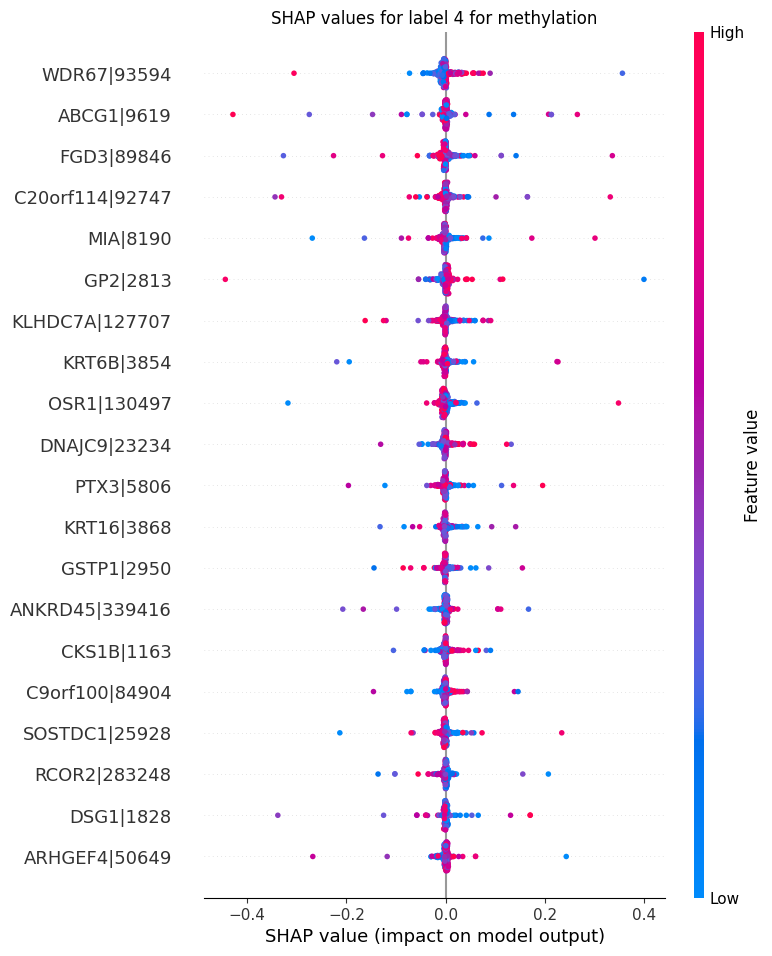

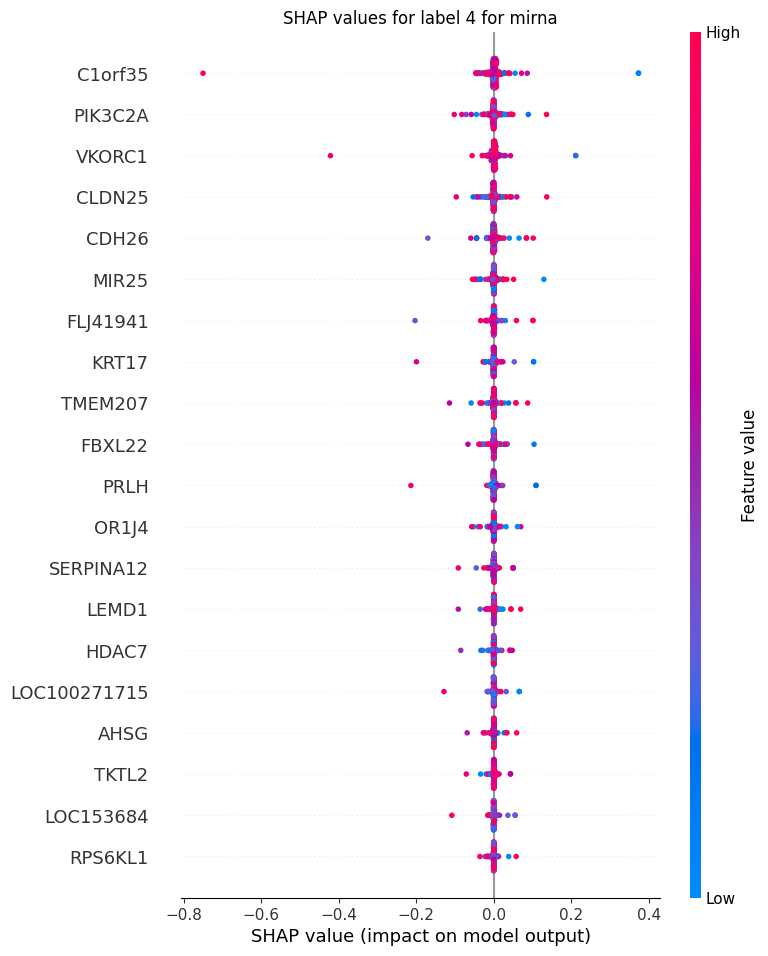

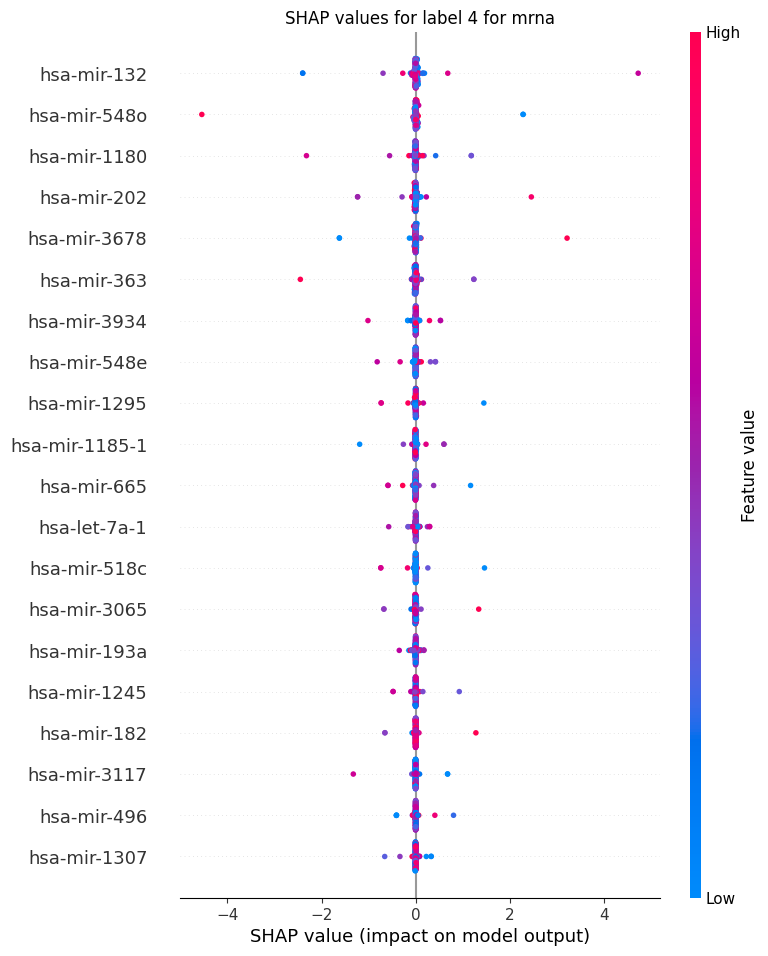

In [65]:
plot_shap_values(shap_values, 4)